In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from typing import List, Dict
import torch
from transformers import AutoModelForCausalLM
import PIL.Image

from deepseek_vl2.models import DeepseekVLV2ForCausalLM, DeepseekVLV2Processor
from deepseek_vl2.serve.app_modules.utils import parse_ref_bbox

/gpfs/projects/CascanteBonillaGroup/jmurrugarral/anaconda3/envs/py10-DS/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Python version is above 3.10, patching the collections module.


In [18]:
!pip install -e .[gradio]

Obtaining file:///gpfs/projects/CascanteBonillaGroup/jmurrugarral/DeepSeek-VL2
  Installing build dependencies ... one
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Building editable for deepseek_vl2 (pyproject.toml) ... done
  Created wheel for deepseek_vl2: filename=deepseek_vl2-1.0.0-0.editable-py3-none-any.whl size=14218 sha256=11f71e4bd9b3171e7c542059d76b5511b0dee1623dc28398665a17b0f043c807
  Stored in directory: /tmp/pip-ephem-wheel-cache-lzk6gx37/wheels/de/8b/b8/b03c337515b5bba6167d9b167fb7610ae0612658ccc7dab3fa
Successfully built deepseek_vl2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.1
    Uninstalling numpy-2.0.1:
      Successful

In [3]:
def load_pil_images(conversations: List[Dict[str, str]]) -> List[PIL.Image.Image]:
    """

    Args:
        conversations (List[Dict[str, str]]): the conversations with a list of messages. An example is :
            [
                {
                    "role": "User",
                    "content": "<image>\nExtract all information from this image and convert them into markdown format.",
                    "images": ["./examples/table_datasets.png"]
                },
                {"role": "Assistant", "content": ""},
            ]

    Returns:
        pil_images (List[PIL.Image.Image]): the list of PIL images.

    """

    pil_images = []

    for message in conversations:
        if "images" not in message:
            continue

        for image_path in message["images"]:
            pil_img = PIL.Image.open(image_path)
            pil_img = pil_img.convert("RGB")
            pil_images.append(pil_img)

    return pil_images

In [4]:
dtype = torch.bfloat16

# specify the path to the model
model_path = "deepseek-ai/deepseek-vl2" # args.model_path
vl_chat_processor: DeepseekVLV2Processor = DeepseekVLV2Processor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: DeepseekVLV2ForCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path,
    trust_remote_code=True,
    torch_dtype=dtype
)
vl_gpt = vl_gpt.cuda().eval()

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: patch_size, add_special_token, image_std, mask_prompt, image_mean, pad_token, image_token, sft_format, normalize, ignore_id, candidate_resolutions, downsample_ratio. 


Add pad token = ['<｜▁pad▁｜>'] to the tokenizer
<｜▁pad▁｜>:2
Add image token = ['<image>'] to the tokenizer
<image>:128815
Add grounding-related tokens = ['<|ref|>', '<|/ref|>', '<|det|>', '<|/det|>', '<|grounding|>'] to the tokenizer with input_ids
<|ref|>:128816
<|/ref|>:128817
<|det|>:128818
<|/det|>:128819
<|grounding|>:128820
Add chat tokens = ['<|User|>', '<|Assistant|>'] to the tokenizer with input_ids
<|User|>:128821
<|Assistant|>:128822



DeepseekVLV2ForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
DeepseekV2ForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [26]:
# single image conversation example
conversation = [
    {
        "role": "<|User|>",
        "content": "<image>\n<image>\n Is the first image in the same orientation than the second one?",
        "images": [
            "images/1.jpg",
            "images/1.jpg"
        ],
    },
    {"role": "<|Assistant|>", "content": ""},
]

In [27]:
pil_images = load_pil_images(conversation)
print(f"len(pil_images) = {len(pil_images)}")

prepare_inputs = vl_chat_processor.__call__(
    conversations=conversation,
    images=pil_images,
    force_batchify=True,
    system_prompt=""
).to(vl_gpt.device, dtype=dtype)

len(pil_images) = 2


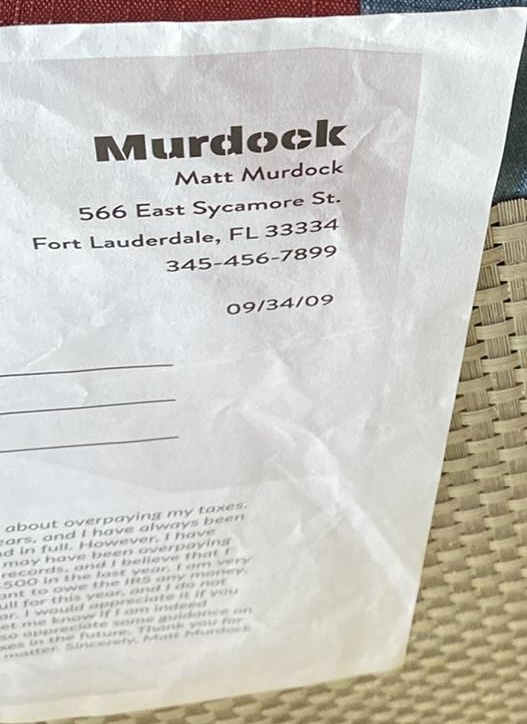

In [28]:
pil_images[0]

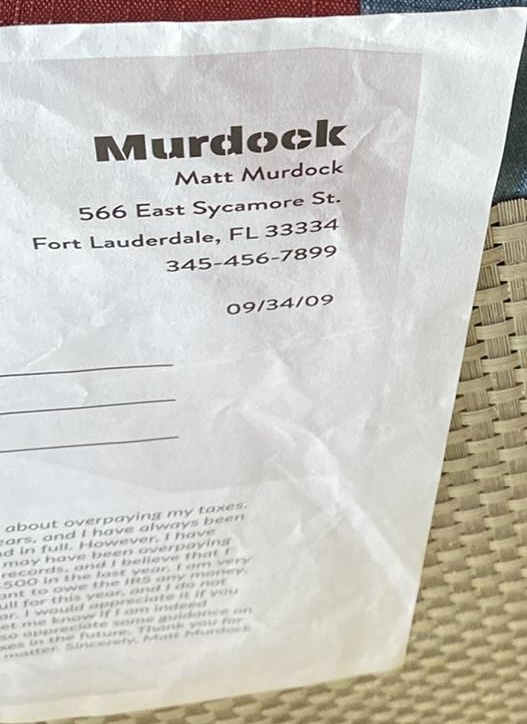

In [29]:
pil_images[1]

In [30]:
chunk_size = -1

with torch.no_grad():

    if chunk_size == -1:
        inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)
        past_key_values = None
    # else:
    #     # incremental_prefilling when using 40G GPU for vl2-small
    #     inputs_embeds, past_key_values = vl_gpt.incremental_prefilling(
    #         input_ids=prepare_inputs.input_ids,
    #         images=prepare_inputs.images,
    #         images_seq_mask=prepare_inputs.images_seq_mask,
    #         images_spatial_crop=prepare_inputs.images_spatial_crop,
    #         attention_mask=prepare_inputs.attention_mask,
    #         chunk_size=args.chunk_size
    #     )

    # run the model to get the response
    outputs = vl_gpt.generate(
        # inputs_embeds=inputs_embeds[:, -1:],
        # input_ids=prepare_inputs.input_ids[:, -1:],
        inputs_embeds=inputs_embeds,
        input_ids=prepare_inputs.input_ids,
        images=prepare_inputs.images,
        images_seq_mask=prepare_inputs.images_seq_mask,
        images_spatial_crop=prepare_inputs.images_spatial_crop,
        attention_mask=prepare_inputs.attention_mask,
        past_key_values=past_key_values,

        pad_token_id=tokenizer.eos_token_id,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=512,

        # do_sample=False,
        # repetition_penalty=1.1,

        do_sample=True,
        temperature=0.4,
        top_p=0.9,
        repetition_penalty=1.1,

        use_cache=True,
    )

answer = tokenizer.decode(outputs[0][len(prepare_inputs.input_ids[0]):].cpu().tolist(), skip_special_tokens=False)
print(f"{prepare_inputs['sft_format'][0]}", answer)

vg_image = parse_ref_bbox(answer, image=pil_images[-1])
# if vg_image is not None:
#     vg_image.save("vg_result.jpg", format="JPEG", quality=85)

<|User|>: <image>
<image>
 Is the first image in the same orientation than the second one?

<|Assistant|>: No, they are not in the same orientation.<｜end▁of▁sentence｜>


In [31]:
# import matplotlib.pyplot as plt

# plt.imshow(vg_image)
# plt.show()

vg_image

In [32]:
import json
from pprint import pprint

with open('/gpfs/projects/CascanteBonillaGroup/datasets/VizWiz-Priv/Annotations/train.json', 'r') as f:
    data = json.load(f)

pprint(data[:10])

[{'image': 'VizWiz_v2_000000031173.jpg', 'private': 0, 'private_regions': []},
 {'image': 'VizWiz_v2_000000031174.jpg', 'private': 0, 'private_regions': []},
 {'image': 'VizWiz_v2_000000031175.jpg', 'private': 0, 'private_regions': []},
 {'image': 'VizWiz_v2_000000031176.jpg', 'private': 0, 'private_regions': []},
 {'image': 'VizWiz_v2_000000031177.jpg',
  'private': 1,
  'private_regions': [{'class': 'Text:Computer Screen',
                       'polygon': [[397, 479],
                                   [535, 473],
                                   [541, 496],
                                   [403, 506]]},
                      {'class': 'Text:Computer Screen',
                       'polygon': [[405, 552],
                                   [574, 543],
                                   [572, 574],
                                   [413, 589]]}]},
 {'image': 'VizWiz_v2_000000031178.jpg', 'private': 0, 'private_regions': []},
 {'image': 'VizWiz_v2_000000031179.jpg', 'private': 0,

In [12]:
directory = "/gpfs/projects/CascanteBonillaGroup/datasets/VizWiz-Priv/HoleMean_Images"
filename = 'VizWiz_v2_000000031177.jpg'

#directory = "/gpfs/projects/CascanteBonillaGroup/datasets/VizWiz-Priv/Filling_Images"
#filename = 'VizWiz_v2_000000031177.png'

img_full_path = os.path.join(directory, filename)

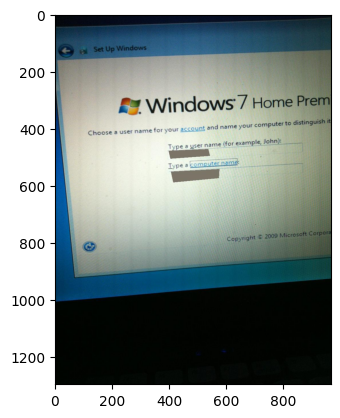

'/gpfs/projects/CascanteBonillaGroup/datasets/VizWiz-Priv/HoleMean_Images/VizWiz_v2_000000031177.jpg'

In [13]:
import matplotlib.pyplot as plt

pil_img = PIL.Image.open(img_full_path)
pil_img = pil_img.convert("RGB")

plt.imshow(pil_img)
plt.show()

img_full_path

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def locate_private_content(img_full_path, prompt, temperature=0.4, pil_images=[]):
    conversation = [
        {
            "role": "<|User|>",
            "content": f"<image>\n<|grounding|>{prompt}.",
            "images": [
                img_full_path
            ],
        },
        {"role": "<|Assistant|>", "content": ""},
    ]

    if not pil_images:
        pil_images = load_pil_images(conversation)
    # print(f"len(pil_images) = {len(pil_images)}")

    prepare_inputs = vl_chat_processor.__call__(
        conversations=conversation,
        images=pil_images,
        force_batchify=True,
        system_prompt=""
    ).to(vl_gpt.device, dtype=dtype)


    with torch.no_grad():

        inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)
        past_key_values = None

        # run the model to get the response
        outputs = vl_gpt.generate(
            # inputs_embeds=inputs_embeds[:, -1:],
            # input_ids=prepare_inputs.input_ids[:, -1:],
            inputs_embeds=inputs_embeds,
            input_ids=prepare_inputs.input_ids,
            images=prepare_inputs.images,
            images_seq_mask=prepare_inputs.images_seq_mask,
            images_spatial_crop=prepare_inputs.images_spatial_crop,
            attention_mask=prepare_inputs.attention_mask,
            past_key_values=past_key_values,

            pad_token_id=tokenizer.eos_token_id,
            bos_token_id=tokenizer.bos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            max_new_tokens=512,

            # do_sample=False,
            # repetition_penalty=1.1,

            do_sample=True,
            temperature=temperature,
            top_p=0.9,
            repetition_penalty=1.1,

            use_cache=True,
        )

    answer = tokenizer.decode(outputs[0][len(prepare_inputs.input_ids[0]):].cpu().tolist(), skip_special_tokens=False)
    print(f"{prepare_inputs['sft_format'][0]}", answer)

    vg_image = parse_ref_bbox(answer, image=pil_images[-1])
    # if vg_image is not None:
    #     vg_image.save("vg_result.jpg", format="JPEG", quality=85)

    if vg_image:
        plt.imshow(vg_image)
        plt.show()

    return answer, vg_image

def crop_image(image_path, bbox):
    # Load the image
    # image_path = '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/668.jpeg'
    image = Image.open(image_path)
    image_h, image_w = image.size

    # box = [568, 746, 661, 998]

    box = (
        int(bbox[0] / 999 * image_h),
        int(bbox[1] / 999 * image_w),
        int(bbox[2] / 999 * image_h),
        int(bbox[3] / 999 * image_w),
    )

    x_min, y_min, x_max, y_max = box
    # print (x_min, y_min, x_max, y_max)

    rotated_image = image.rotate(360)

    # Crop the region
    cropped_image = rotated_image.crop((x_min, y_min, x_max, y_max))

    # Save or show the cropped image
    # cropped_image.save('cropped_image.jpg')
    # rotated_image.show()
    cropped_image.show()

    return cropped_image

<|User|>: <image>
<|grounding|>Locate all words in a fine-grained style.

<|Assistant|>: <|ref|>home screen<|/ref|><|det|>[[0, 31, 995, 785]]<|/det|><｜end▁of▁sentence｜>


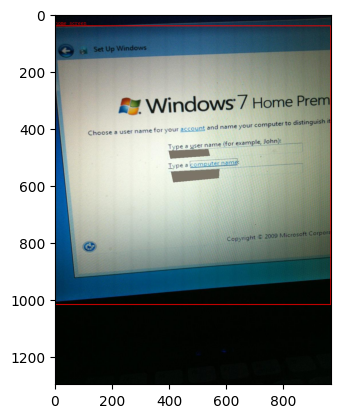

('<|ref|>home screen<|/ref|><|det|>[[0, 31, 995, 785]]<|/det|><｜end▁of▁sentence｜>',
 <PIL.Image.Image image mode=RGB size=968x1296>)

In [33]:
locate_private_content(img_full_path, "Locate all words in a fine-grained style", temperature = 0.9)

In [34]:
import glob

folder_path = "/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images"

# List all files (non-recursively)
files = glob.glob(folder_path + "/*")

print(files)

['/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/848.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/938.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/545.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/53.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/730.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/498.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/1166.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/225.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/130.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/662.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/10.jpeg', '/gpfs/projects/CascanteBonillaGroup/datase

/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/848.jpeg
<|User|>: <image>
<|grounding|>Locate all private objects in the image.

<|Assistant|>: <|ref|>paper box<|/ref|><|det|>[[267, 354, 379, 599], [303, 0, 709, 323], [403, 225, 731, 518], [516, 402, 815, 999]]<|/det|><｜end▁of▁sentence｜>


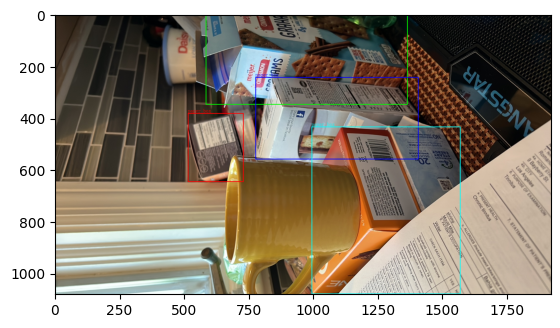

<|ref|>paper box<|/ref|><|det|>[[267, 354, 379, 599], [303, 0, 709, 323], [403, 225, 731, 518], [516, 402, 815, 999]]<|/det|><｜end▁of▁sentence｜>


In [43]:
for img_full_path in files:
    print (img_full_path)
    answer, vg_image = locate_private_content(img_full_path, "Locate all private objects in the image")

    print (answer)
    break

/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/938.jpeg
<|User|>: <image>
<|grounding|>Locate paper document in the image.

<|Assistant|>: <|ref|>paper document<|/ref|><|det|>[[165, 0, 543, 487]]<|/det|><｜end▁of▁sentence｜>


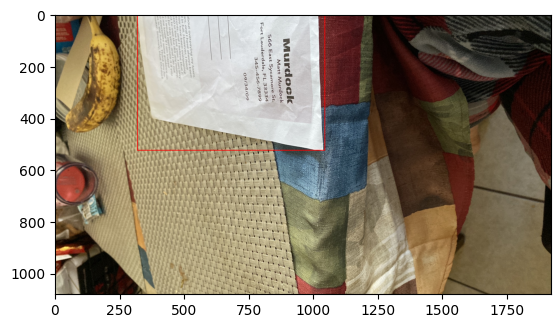

<|ref|>paper document<|/ref|><|det|>[[165, 0, 543, 487]]<|/det|><｜end▁of▁sentence｜>
------
<re.Match object; span=(0, 29), match='<|ref|>paper document<|/ref|>'>
<re.Match object; span=(29, 64), match='<|det|>[[165, 0, 543, 487]]<|/det|>'>
------
paper document
[[165, 0, 543, 487]]
------
ref: paper document
det: [[165, 0, 543, 487]]


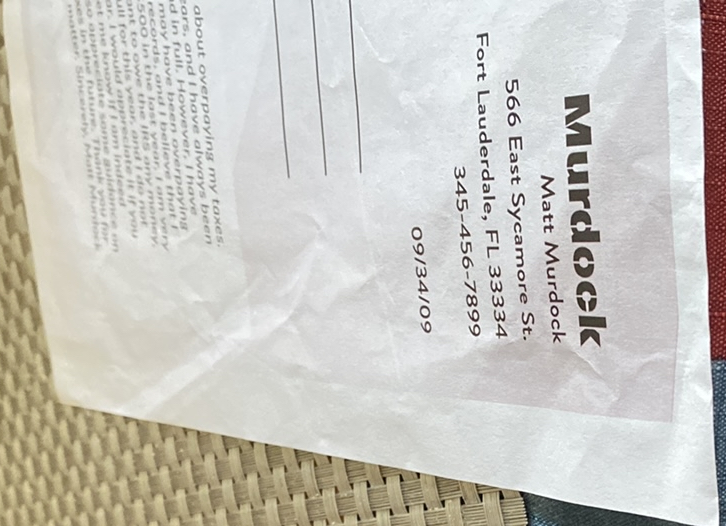

<|User|>: <image>
<|grounding|>What is written in the paper?.

<|Assistant|>: The paper contains <|ref|>a name<|/ref|><|det|>[[743, 249, 909, 670]]<|/det|> , which is Murdock, and there's also <|ref|>an address<|/ref|><|det|>[[565, 74, 749, 334]]<|/det|> listed. Additionally, there are <|ref|>three lines<|/ref|><|det|>[[259, 0, 509, 489]]<|/det|> that seem to be for writing information, and a <|ref|>phone number<|/ref|><|det|>[[345, 624, 499, 769]]<|/det|> .<｜end▁of▁sentence｜>


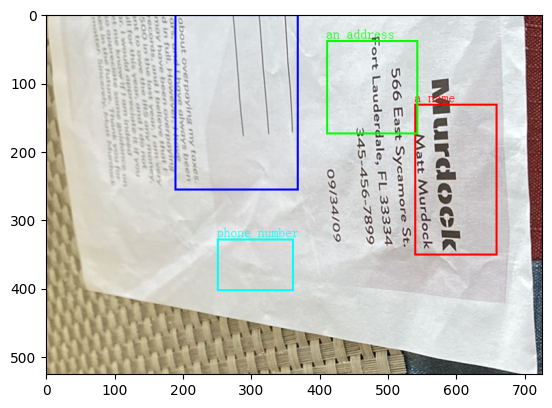

In [44]:
import re
import ast

for img_full_path in files[1:]:
    print (img_full_path)
    answer, vg_image = locate_private_content(img_full_path, "Locate paper document in the image", temperature=0.4)

    print(answer)
    print("------")
    
    # Regular expressions to extract content between tags
    ref_match = re.search(r"<\|ref\|>(.*?)<\|/ref\|>", answer)
    det_match = re.search(r"<\|det\|>(.*?)<\|/det\|>", answer)

    print(ref_match)
    print(det_match)
    print("------")
    
    
    # Extracted values
    ref_value = ref_match.group(1) if ref_match else None
    det_value = det_match.group(1) if det_match else None

    print(ref_value)
    print(det_value)
    print("------")

    
    # Convert 'det' value from string to list
    det_array = ast.literal_eval(det_value) if det_value else None

    # Print the results
    print(f"ref: {ref_value}")
    print(f"det: {det_array}")

    cropped_image = crop_image(img_full_path, det_array[0])
    cropped_image.save('cropped_image.jpg')

    answer_cropped, vg_image_cropped = answer, vg_image = locate_private_content(_, "What is written in the paper?", temperature=0.1, pil_images=[cropped_image])
    break

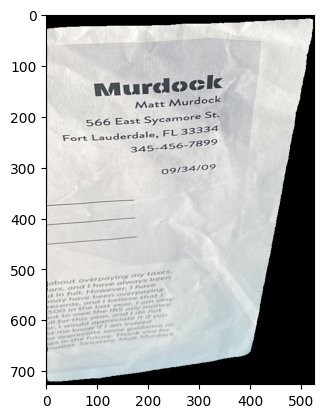

<|User|>: <image>
<|grounding|>Locate the phrase Murdock.

<|Assistant|>:  כאןP.configureinput tüm mạnh_;

ategor/�.env/� Gam/�atten� Mỹ"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
<|User|>: <image>
<|grounding|>Locate the phrase Matt Murdock.

<|Assistant|>:  כאן aspirationsées绿色 tüm mạnh_;

.Graphics/�Conf/� technically/�losing� Mỹ"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

(' כאן WHETHER tüm mạnh_;\n\n3/�);\r\n/�-show/�"),\r\n� Mỹ"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',
 None)

In [77]:
directory = "/gpfs/projects/CascanteBonillaGroup/jmurrugarral/DeepSeek-VL2"
filename = 'masked_image.jpg'

#directory = "/gpfs/projects/CascanteBonillaGroup/datasets/VizWiz-Priv/Filling_Images"
#filename = 'VizWiz_v2_000000031177.png'

img_full_path = os.path.join(directory, filename)

import matplotlib.pyplot as plt

pil_img = PIL.Image.open(img_full_path)
pil_img = pil_img.convert("RGB")

plt.imshow(pil_img)
plt.show()

img_full_path

locate_private_content(img_full_path, "Locate the phrase Murdock", temperature = 1)
locate_private_content(img_full_path, "Locate the phrase Matt Murdock", temperature = 1)
locate_private_content(img_full_path, "Locate the phrase 566 East Sycamore St.", temperature = 1)
locate_private_content(img_full_path, "Locate the phrase Fort Lauderdale, FL 32234", temperature = 1)
locate_private_content(img_full_path, "Locate the phrase 345-456-7899", temperature = 1)
locate_private_content(img_full_path, "Locate the phrase 09/34/09", temperature = 1)
locate_private_content(img_full_path, "about overpaying my taxes, ars, and I have always beend in full. However, I havemay have been overpayingrecords, a I tell themselves that I 500 in the last year, I money. In the the IHS and do not int to this year, I state it if you will for would confirm an indeed or. I know if I am in needed to improve the future. Thank you how to give the future, Thank you know enter the future, Thank you know", temperature = 1)

In [58]:
#!pip install segment-anything

In [59]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

/gpfs/projects/CascanteBonillaGroup/jmurrugarral/anaconda3/envs/py10-deepseek/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [60]:
mask_generator = SamAutomaticMaskGenerator(sam)

# mask_generator = SamAutomaticMaskGenerator(
#     model=sam,
#     points_per_side=32,
#     pred_iou_thresh=0.86,
#     stability_score_thresh=0.92,
#     crop_n_layers=1,
#     crop_n_points_downscale_factor=2,
#     min_mask_region_area=100,  # Requires open-cv to run post-processing
# )

In [61]:
#!pip install opencv-python

In [62]:
import cv2

image_to_sam = cv2.imread('cropped_image.jpg')
image_to_sam = cv2.cvtColor(image_to_sam, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(image_to_sam)

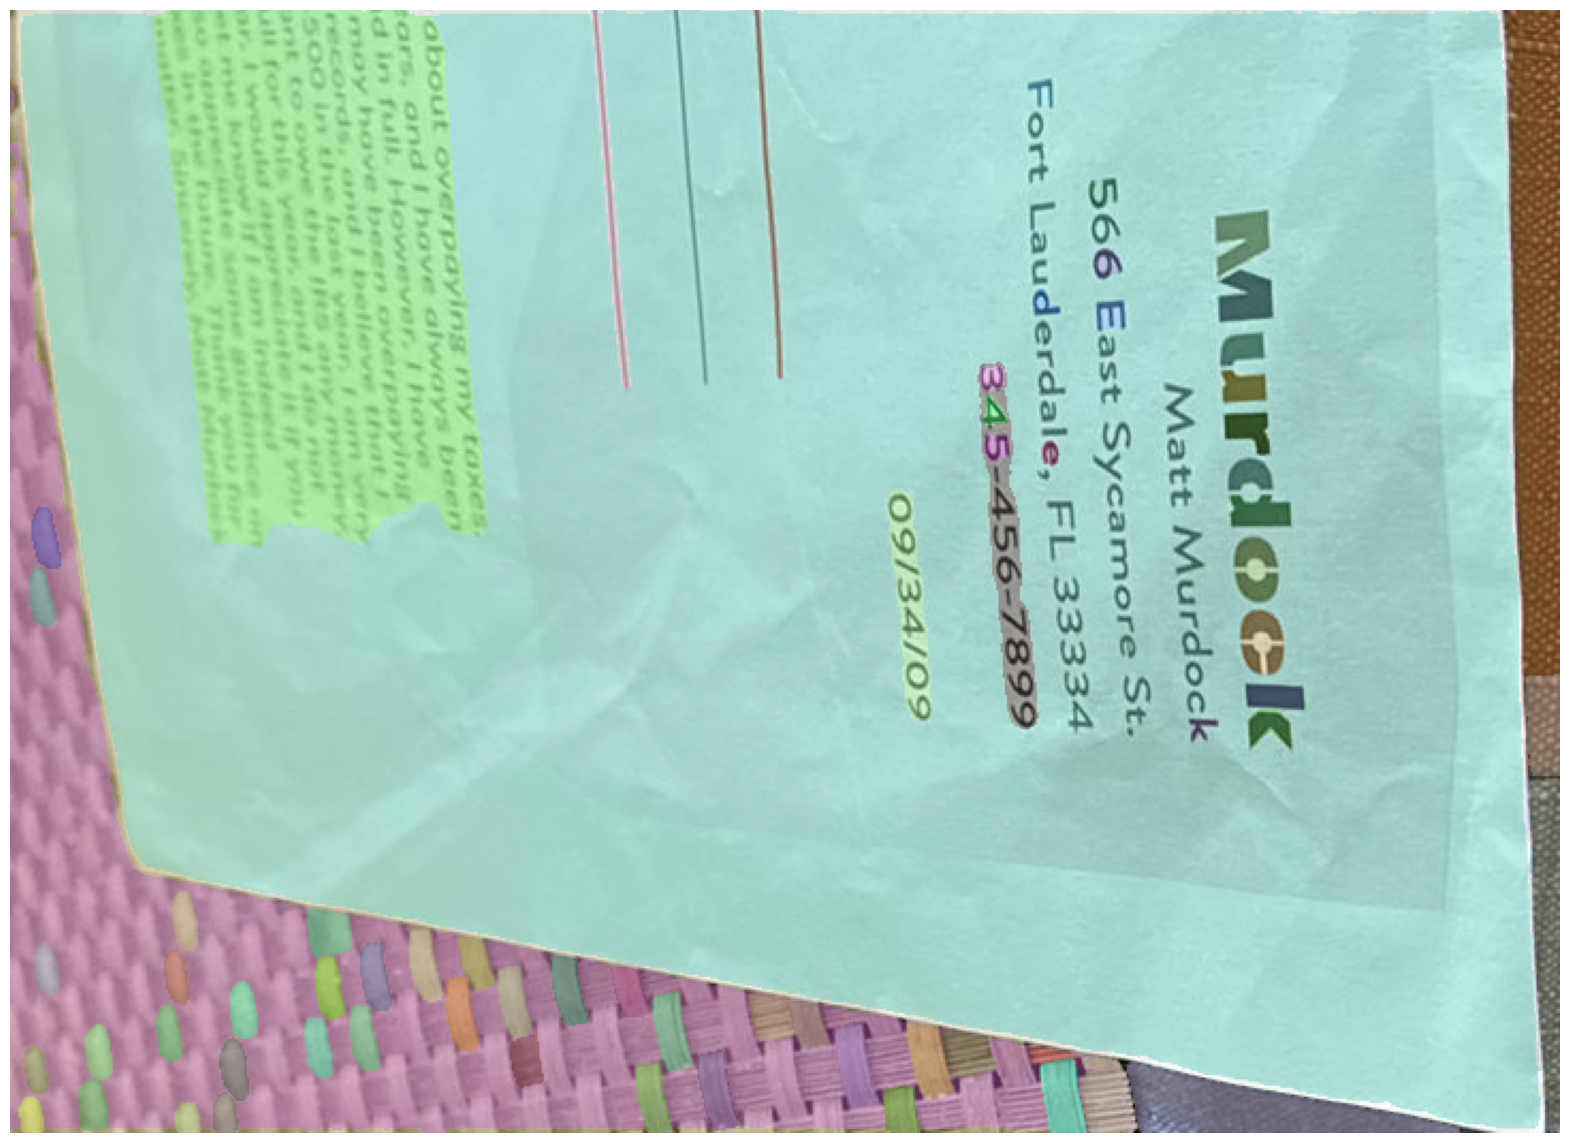

In [63]:
import numpy as np

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

plt.figure(figsize=(20,20))
plt.imshow(image_to_sam)
show_anns(masks)
plt.axis('off')
plt.show()

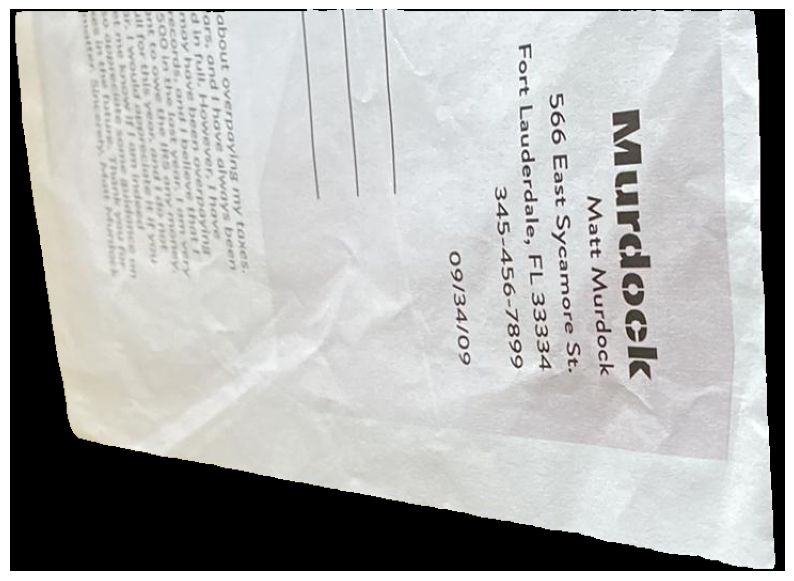

In [64]:
def set_zero_outside_mask(image, mask):
    """Sets pixel values outside the mask to 0."""

    # Ensure image and mask have compatible shapes
    if image.shape[:2] != mask.shape:
        raise ValueError("Image and mask must have the same height and width.")

    # Create a copy of the image to avoid modifying the original
    masked_image = image.copy()

    # Set values outside mask to 0
    masked_image[~mask] = 0

    return masked_image


# Example usage (assuming you have the 'image' and 'masks' from your previous code)
# image_path = 'images/848.jpeg'
# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Example with masks[2]:
masked_image = set_zero_outside_mask(image_to_sam, masks[0]['segmentation'])

plt.figure(figsize=(10, 10))
plt.imshow(masked_image)
plt.axis('off')
plt.show()

In [65]:
#!pip install tiktoken verovio

In [66]:
# !pip install tiktoken verovio

from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('ucaslcl/GOT-OCR2_0', trust_remote_code=True)
model = AutoModel.from_pretrained('ucaslcl/GOT-OCR2_0', trust_remote_code=True, low_cpu_mem_usage=True, device_map='cuda', use_safetensors=True, pad_token_id=tokenizer.eos_token_id)
model = model.eval().cuda()

A new version of the following files was downloaded from https://huggingface.co/ucaslcl/GOT-OCR2_0:
- tokenization_qwen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ucaslcl/GOT-OCR2_0:
- modeling_GOT.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ucaslcl/GOT-OCR2_0:
- modeling_GOT.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [67]:
cv2.imwrite('masked_image.jpg', masked_image)

# masked_image_rotated_90_ccw = cv2.rotate(masked_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
# cv2.imwrite('masked_image.jpg', masked_image_rotated_90_ccw)

def rotate(masked_image, angle=45):
    # Get image dimensions
    (h, w) = masked_image.shape[:2]
    center = (w // 2, h // 2)

    # Rotate by 45 degrees
    # angle = 45
    scale = 1.0  # Keep the original scale

    # Get the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)

    # Perform the rotation
    return cv2.warpAffine(masked_image, rotation_matrix, (w, h))


for n in range (4):
    image_file = 'masked_image.jpg'

    # plain texts OCR
    res = model.chat(tokenizer, image_file, ocr_type='ocr')
    print (res)
    print ("====\n")

    # format texts OCR:
    res = model.chat(tokenizer, image_file, ocr_type='format')
    print (res)
    print ("====\n")

    # # fine-grained OCR:
    # res = model.chat(tokenizer, image_file, ocr_type='ocr', ocr_box='')
    # print (res)
    # print ("====\n")
    # res = model.chat(tokenizer, image_file, ocr_type='format', ocr_box='')
    # print (res)
    # print ("====\n")
    # res = model.chat(tokenizer, image_file, ocr_type='ocr', ocr_color='')
    # print (res)
    # print ("====\n")
    # res = model.chat(tokenizer, image_file, ocr_type='format', ocr_color='')
    # print (res)
    # print ("====\n")

    # multi-crop OCR:
    res = model.chat_crop(tokenizer, image_file, ocr_type='ocr')
    print (res)
    print ("====\n")
    res = model.chat_crop(tokenizer, image_file, ocr_type='format')
    print (res)
    print ("====\n")

    # masked_image_rotated_90_ccw = cv2.rotate(masked_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    # cv2.imwrite('masked_image.jpg', masked_image_rotated_90_ccw)

    masked_image_rotated = rotate(masked_image)
    cv2.imwrite('masked_image.jpg', masked_image_rotated)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Fort Lauderdale, FL 33334 566 East Sycamore St.  Murd ock 345-456-7899 Mat Murdock 09/34/09
====

\text{Fort Lauderdale, FL 33334}
\text{566 East Sycamore St.}
\text{MurroCK}
\text{Matt Murdock}
\text{09/13/24/09}
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])
Fort Lauderdale, FL 33334 566 East Sycamore St.  Murdock 345-456-7899
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


\text{Fort Lauderdale, FL 33334}
\text{566 East Sycamore St.}
\text{Murdoch, FL 33334}
\text{Matt Murdock}
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


566 345-456-7899 668/60
====

\text{566 East Sycamore St.}
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])
566 East Sycamore St.
Murdock
Murdock
345-456-7899
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


\text{566 East Sycamore St.}
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


566 345-456-7899 668/60
====

\text{566 East Sycamore St.}
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])
566 East Sycamore St.
Murdock
Murdock
345-456-7899
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


\text{566 East Sycamore St.}
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


566 345-456-7899 668/60
====

\text{566 East Sycamore St.}
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])
566 East Sycamore St.
Murdock
Murdock
345-456-7899
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09
60/34/09


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])
\text{566 East Sycamore St.}
====



In [68]:
# res = model.chat(tokenizer, image_file, ocr_type='format', render=True, save_render_file = './demo_ocr.html')
# print(res)

In [69]:
# import sys
# !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
# !pip install opencv-python

# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [70]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [71]:
mask_generator = SamAutomaticMaskGenerator(sam)

# mask_generator = SamAutomaticMaskGenerator(
#     model=sam,
#     points_per_side=32,
#     pred_iou_thresh=0.86,
#     stability_score_thresh=0.92,
#     crop_n_layers=1,
#     crop_n_points_downscale_factor=2,
#     min_mask_region_area=100,  # Requires open-cv to run post-processing
# )

In [72]:
import cv2

image_to_sam = cv2.imread('cropped_image.jpg')
image_to_sam = cv2.cvtColor(image_to_sam, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(image_to_sam)

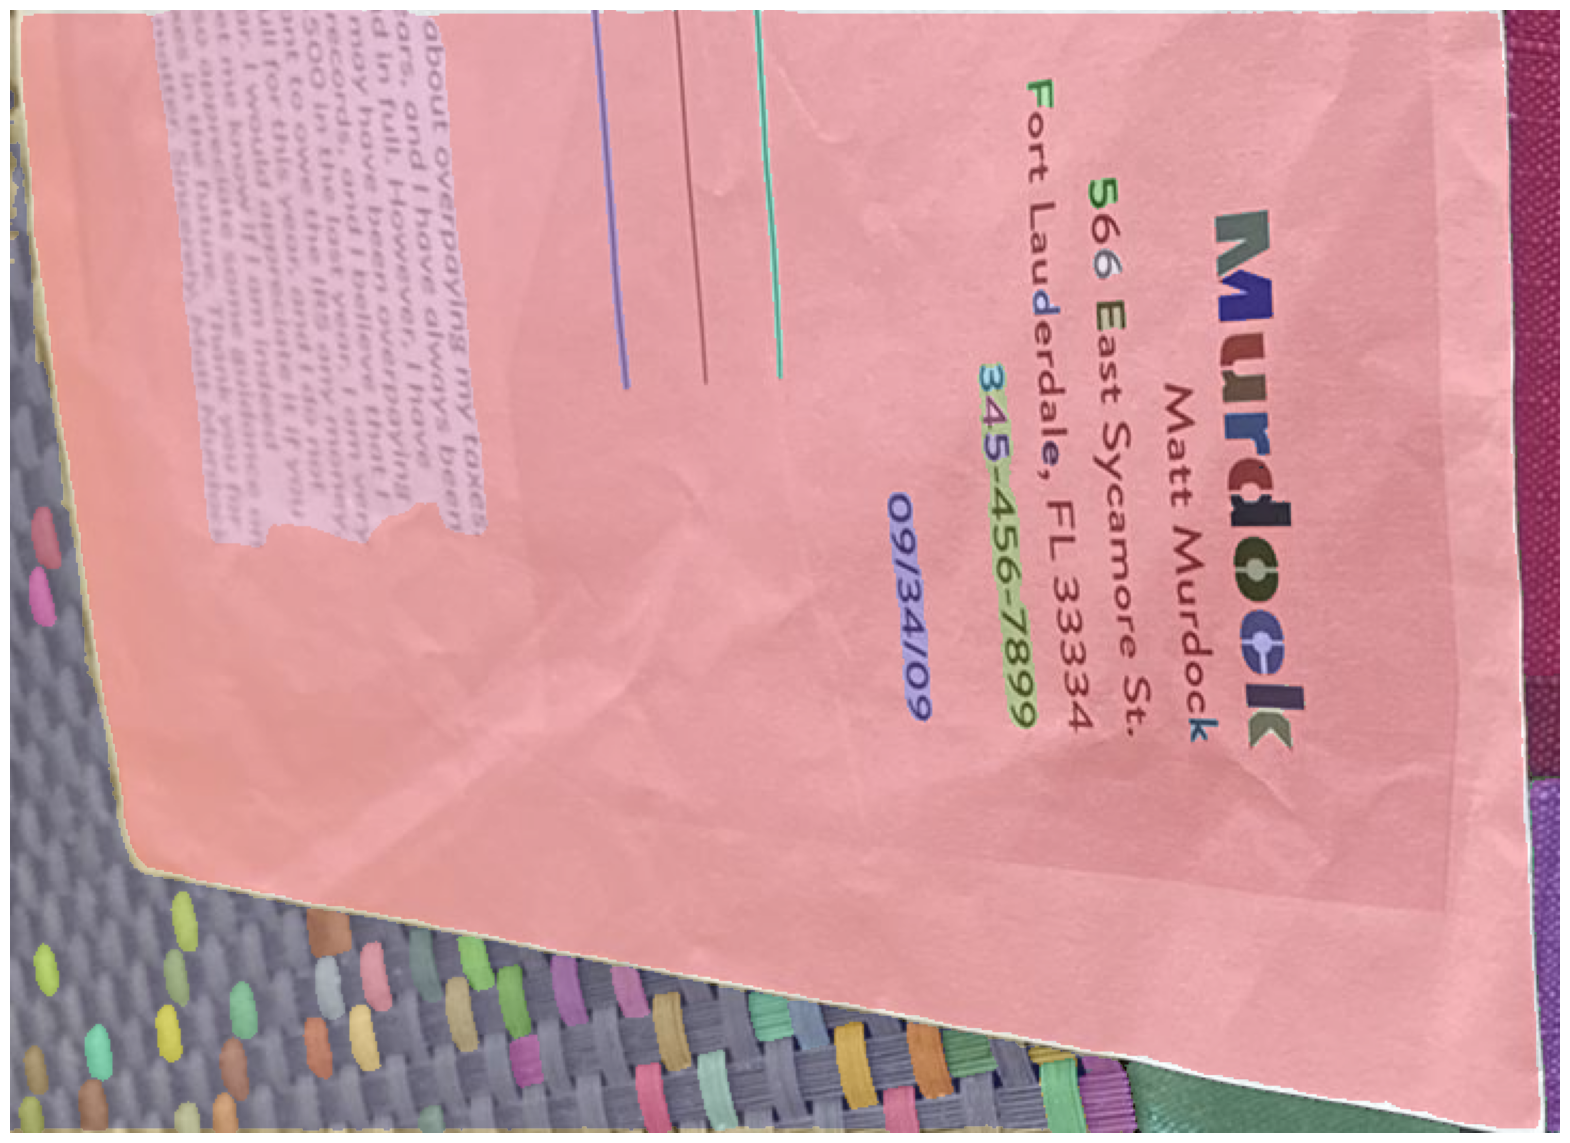

In [73]:
import numpy as np

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

plt.figure(figsize=(20,20))
plt.imshow(image_to_sam)
show_anns(masks)
plt.axis('off')
plt.show()

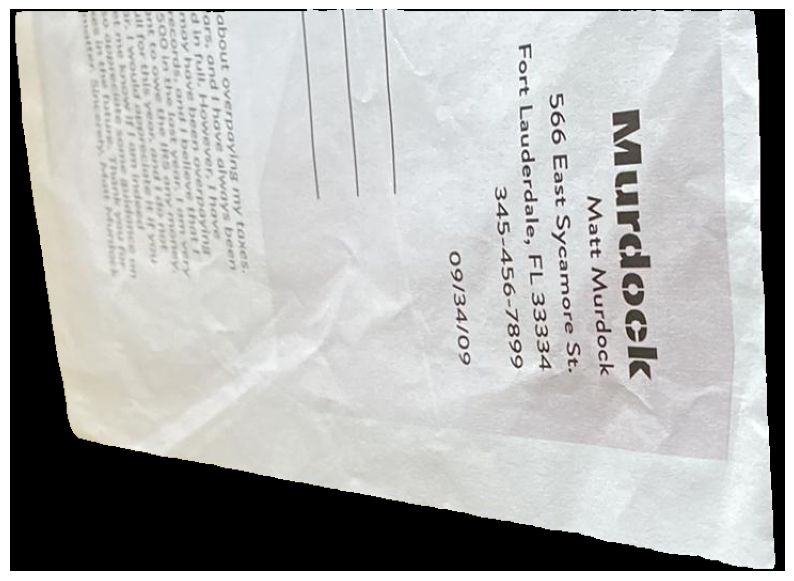

In [74]:
def set_zero_outside_mask(image, mask):
    """Sets pixel values outside the mask to 0."""

    # Ensure image and mask have compatible shapes
    if image.shape[:2] != mask.shape:
        raise ValueError("Image and mask must have the same height and width.")

    # Create a copy of the image to avoid modifying the original
    masked_image = image.copy()

    # Set values outside mask to 0
    masked_image[~mask] = 0

    return masked_image


# Example usage (assuming you have the 'image' and 'masks' from your previous code)
# image_path = 'images/848.jpeg'
# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Example with masks[2]:
masked_image = set_zero_outside_mask(image_to_sam, masks[0]['segmentation'])

plt.figure(figsize=(10, 10))
plt.imshow(masked_image)
plt.axis('off')
plt.show()

In [75]:
cv2.imwrite('masked_image.jpg', masked_image)

# masked_image_rotated_90_ccw = cv2.rotate(masked_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
# cv2.imwrite('masked_image.jpg', masked_image_rotated_90_ccw)

for n in range (4):
    image_file = 'masked_image.jpg'

    # plain texts OCR
    res = model.chat(tokenizer, image_file, ocr_type='ocr')
    print (res)
    print ("====\n")

    # format texts OCR:
    res = model.chat(tokenizer, image_file, ocr_type='format')
    print (res)
    print ("====\n")

    # # fine-grained OCR:
    # res = model.chat(tokenizer, image_file, ocr_type='ocr', ocr_box='')
    # print (res)
    # print ("====\n")
    # res = model.chat(tokenizer, image_file, ocr_type='format', ocr_box='')
    # print (res)
    # print ("====\n")
    # res = model.chat(tokenizer, image_file, ocr_type='ocr', ocr_color='')
    # print (res)
    # print ("====\n")
    # res = model.chat(tokenizer, image_file, ocr_type='format', ocr_color='')
    # print (res)
    # print ("====\n")

    # multi-crop OCR:
    res = model.chat_crop(tokenizer, image_file, ocr_type='ocr')
    print (res)
    print ("====\n")
    res = model.chat_crop(tokenizer, image_file, ocr_type='format')
    print (res)
    print ("====\n")

    masked_image_rotated_90_ccw = cv2.rotate(masked_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    cv2.imwrite('masked_image.jpg', masked_image_rotated_90_ccw)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Fort Lauderdale, FL 33334 566 East Sycamore St.  Murd ock 345-456-7899 Mat Murdock 09/34/09
====

\text{Fort Lauderdale, FL 33334}
\text{566 East Sycamore St.}
\text{MurroCK}
\text{Matt Murdock}
\text{09/13/24/09}
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])
Fort Lauderdale, FL 33334 566 East Sycamore St.  Murdock 345-456-7899
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


\text{Fort Lauderdale, FL 33334}
\text{566 East Sycamore St.}
\text{Murdoch, FL 33334}
\text{Matt Murdock}
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Mur do ek Matt Murdock 566 East Sycamore St.  Fort Lauderdale, FL 33334 345-456-7899 09/34/09
====

\title{
Murdock
}
Matt Murdock
566 East Sycamore St.
Fort Lauderdale, FL 33334
345-456-7899
09/34/09
about overpaying my taxes,
ars, and I have always been
d in full. However, I have
may have been overpaying
records, a I tell themselves that I
500 in the last year, I money.
In the the IHS and do not
int to this year, I state it if you
will for would confirm an indeed
or. I know if I am in needed
to improve the future. Thank you how
to give the future, Thank you know
enter the future, Thank you know
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])
Murdle Matt Murdock 566 East Sycamore St.  Fort Lauderdale, FL 33334 345-456-7899 09/34/09 about overpaying my to xes.  ars. and I have always been d in full. However, I have noh in the year, I money.  500 in the the Irs a fide not into this year, 111 for the 111 for
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


\title{
Murdle
}
Matt Murdock
566 East Sycamore St.
Fort Lauderdale, FL 33334
345-456-7899
09/34/09
about overpaying my taxes, ars. and I have always been
d in full. However, I have
may have been overpaying
records, and I believe that I
costs. I'm not your
500 in the the IHS and do not
int to this year, I'm
all for you. I'm also
for. I know if I am indeed
it hope make a message from
to the future. Thank you for
matter the future, I'm
1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Mur do ek Matt Murdock 566 East Sycamore St.  Fort Lauderdale, FL 33334 345-456-7899 09/34/09
====

\title{
Murdock
}
Matt Murdock
566 East Sycamore St.
Fort Lauderdale, FL 33334
345-456-7899
09/34/09
about overpaying my taxes,
ars, and I have always been
d in full. However, I have
may have been overpaying
records, a I tell themselves that I
500 in the last year, I money.
In the the IHS and do not
int to this year, I state it if you
will for would confirm an indeed
or. I know if I am in needed
to improve the future. Thank you how
to give the future, Thank you know
enter the future, Thank you know
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])
Murdle Matt Murdock 566 East Sycamore St.  Fort Lauderdale, FL 33334 345-456-7899 09/34/09 about overpaying my to xes.  ars. and I have always been d in full. However, I have noh in the year, I money.  500 in the the Irs a fide not into this year, 111 for the 111 for
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


\title{
Murdle
}
Matt Murdock
566 East Sycamore St.
Fort Lauderdale, FL 33334
345-456-7899
09/34/09
about overpaying my taxes, ars. and I have always been
d in full. However, I have
may have been overpaying
records, and I believe that I
costs. I'm not your
500 in the the IHS and do not
int to this year, I'm
all for you. I'm also
for. I know if I am indeed
it hope make a message from
to the future. Thank you for
matter the future, I'm
1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Mur do ek Matt Murdock 566 East Sycamore St.  Fort Lauderdale, FL 33334 345-456-7899 09/34/09
====

\title{
Murdock
}
Matt Murdock
566 East Sycamore St.
Fort Lauderdale, FL 33334
345-456-7899
09/34/09
about overpaying my taxes,
ars, and I have always been
d in full. However, I have
may have been overpaying
records, a I tell themselves that I
500 in the last year, I money.
In the the IHS and do not
int to this year, I state it if you
will for would confirm an indeed
or. I know if I am in needed
to improve the future. Thank you how
to give the future, Thank you know
enter the future, Thank you know
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])
Murdle Matt Murdock 566 East Sycamore St.  Fort Lauderdale, FL 33334 345-456-7899 09/34/09 about overpaying my to xes.  ars. and I have always been d in full. However, I have noh in the year, I money.  500 in the the Irs a fide not into this year, 111 for the 111 for
====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])
\title{
Murdle
}
Matt Murdock
566 East Sycamore St.
Fort Lauderdale, FL 33334
345-456-7899
09/34/09
about overpaying my taxes, ars. and I have always been
d in full. However, I have
may have been overpaying
records, and I believe that I
costs. I'm not your
500 in the the IHS and do not
int to this year, I'm
all for you. I'm also
for. I know if I am indeed
it hope make a message from
to the future. Thank you for
matter the future, I'm
100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

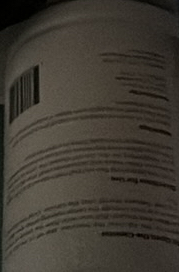

In [76]:
from PIL import Image

# Load the image
image_path = '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/668.jpeg'
image = Image.open(image_path)
image_h, image_w = image.size

box = [568, 746, 661, 998]

box = (
    int(box[0] / 999 * image_h),
    int(box[1] / 999 * image_w),
    int(box[2] / 999 * image_h),
    int(box[3] / 999 * image_w),
)

x_min, y_min, x_max, y_max = box
# print (x_min, y_min, x_max, y_max)

rotated_image = image.rotate(360)

# Crop the region
cropped_image = rotated_image.crop((x_min, y_min, x_max, y_max))

# Save or show the cropped image
# cropped_image.save('cropped_image.jpg')
# rotated_image.show()
cropped_image.show()